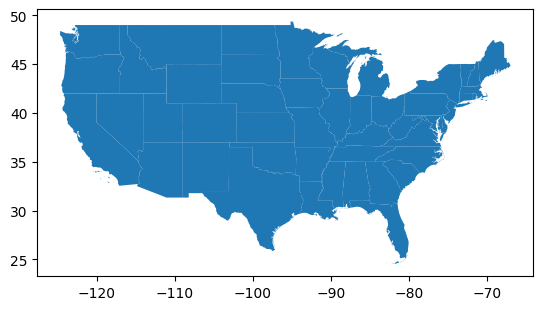

In [1]:
# Imports
import h3
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely
from shapely.ops import unary_union
from shapely.geometry import mapping, Polygon
import os

# Read shapefile
gdf = gpd.read_file(r"Z:\dbcenter\dbgis\admin_usa\states\CONUS.shp")

# Get US without territories / Alaska + Hawaii
us = gdf[~gdf.NAME.isin(["Hawaii", "Alaska", "American Samoa", 
                         "United States Virgin Islands", "Guam",
                         "Commonwealth of the Northern Mariana Islands",
                         "Puerto Rico"])]

# Plot it
fig, ax = plt.subplots(1,1)
us.plot(ax=ax)
plt.show()

30991


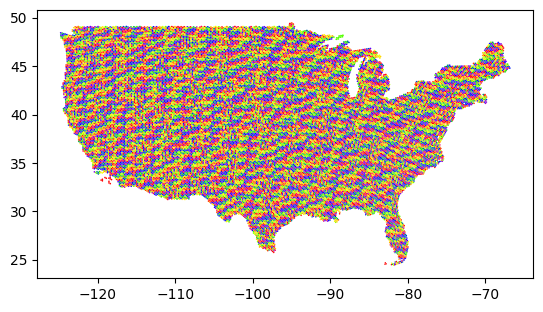

In [ ]:
# # Convert to EPSG 4326 for compatibility with H3 Hexagons
# # us = us.to_crs(epsg=4326)

# # Get union of the shape (whole US)
# union_poly = unary_union(us.geometry.to_crs(5070).buffer(2000).to_crs(4326))
us_corrected = us.copy().to_crs(5070).dissolve()
us_corrected['geometry'] = us_corrected['geometry'].buffer(10000)
us_corrected = us_corrected.to_crs(4326)
us_corrected = us_corrected.loc[us_corrected.geometry.is_valid]
union_poly = unary_union(us_corrected.geometry)


# Find the hexagons within the shape boundary using PolyFill
hex_list=[]
for n, g in enumerate(union_poly.geoms):

    h3_geom = h3.geo_to_h3shape(g)
    hex_list.extend(h3.polygon_to_cells(h3_geom, 5))

# Create hexagon data frame
us_hex = pd.DataFrame(hex_list,columns=["hex_id"])

# Create hexagon geometry and GeoDataFrame
us_hex['geometry'] = [Polygon(h3.cell_to_boundary(x)) for x in us_hex["hex_id"]]
us_hex = gpd.GeoDataFrame(us_hex, crs="EPSG:4326")

us_hex['geometry'] = us_hex['geometry'].map(lambda poly: shapely.ops.transform(swap_xy, poly))
print(len(us_hex))

# Plot the thing
fig, ax = plt.subplots(1,1)
us_hex.plot(ax=ax, cmap="prism")
plt.show()

os.makedirs(r'C:\Users\dh2306\Desktop\US_H3_res5', exist_ok=True)
us_hex.to_file(r'C:\Users\dh2306\Desktop\US_H3_res5\us_h3_res5.shp')


In [97]:
# generate a 10km x 10km grid over the US
us_corrected = us_corrected.to_crs(5070)
minx, miny, maxx, maxy = us_corrected.total_bounds
grid_cells = []
grid_size = 10000  # 10 km
for x0 in range(int(minx), int(maxx), grid_size):
    for y0 in range(int(miny), int(maxy), grid_size):
        x1 = x0 + grid_size
        y1 = y0 + grid_size
        grid_cells.append(Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)]))
grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs="EPSG:5070")
grid = grid[grid.intersects(us_corrected.union_all().buffer(-1000))]  # ensure grid cells are within US boundary

os.makedirs(r'C:\Users\dh2306\Desktop\US_10km_grid', exist_ok=True)
grid.to_file(r'C:\Users\dh2306\Desktop\US_10km_grid\us_10km_grid.shp')

In [2]:
train_samples_gdf = gpd.read_parquet(r"d:\chesapeake_bay_2022_2024edition\samples.par")

In [5]:
train_samples_gdf['geometry'] = train_samples_gdf['geometry'].centroid
out_path = r"d:\chesapeake_bay_2022_2024edition\shapefiles\train_samples_centroids\train_samples_centroids.shp"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
train_samples_gdf.to_file(out_path)

In [15]:
footprint_gdf = gpd.read_file(r"d:\chesapeake_bay_2022_2024edition\footprint.gpkg")
footprint_gdf['geometry'] = footprint_gdf['geometry'].simplify(100)
footprint_gdf = footprint_gdf.dissolve()

out_path = r"d:\chesapeake_bay_2022_2024edition\shapefiles\footprint\footprint.shp"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
footprint_gdf.to_file(out_path)

C:\Users\dh2306\AppData\Local\Temp\ipykernel_77848\430168991.py:7: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  footprint_gdf.to_file(out_path)
c:\Users\dh2306\projects\s2flow\.venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'raster_path' to 'raster_pat'
  ogr_write(


In [18]:
assessment_points_gdf = gpd.read_parquet(r"d:\chesapeake_bay_2022_2024edition\assessment_points.par")
out_path = r"d:\chesapeake_bay_2022_2024edition\shapefiles\assessment_points\assessment_points.shp"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
assessment_points_gdf.to_file(out_path)

In [31]:
# create h3 grid over footprint_gdf
union_poly = unary_union(footprint_gdf.buffer(100).to_crs(4326).geometry)

def swap_xy(x, y):
    return y, x

# Find the hexagons within the shape boundary using PolyFill
if isinstance(union_poly, shapely.geometry.MultiPolygon):
    hex_list=[]
    for n, g in enumerate(union_poly.geoms):

        h3_geom = h3.geo_to_h3shape(g)
        hex_list.extend(h3.polygon_to_cells(h3_geom, 6))
else:
    h3_geom = h3.geo_to_h3shape(union_poly)
    hex_list = h3.polygon_to_cells(h3_geom, 6)

# Create hexagon data frame
cpb_hex = pd.DataFrame(hex_list,columns=["hex_id"])

# Create hexagon geometry and GeoDataFrame
cpb_hex['geometry'] = [Polygon(h3.cell_to_boundary(x)) for x in cpb_hex["hex_id"]]
cpb_hex = gpd.GeoDataFrame(cpb_hex, crs="EPSG:4326")

cpb_hex['geometry'] = cpb_hex['geometry'].map(lambda poly: shapely.ops.transform(swap_xy, poly))
print(len(cpb_hex))

7247


In [39]:
h3.geo_to_cells(cpb_hex['geometry'].iloc[0], 6)

['862aa1c5fffffff']

In [50]:
# aggregate train samples by h3 hex
train_samples_gdf['h3_6'] = train_samples_gdf['geometry'].to_crs(4326).apply(lambda geom: h3.latlng_to_cell(geom.y, geom.x, 6))
cpb_hex['train_sample_count'] = cpb_hex['hex_id'].map(train_samples_gdf['h3_6'].value_counts()).fillna(0).astype(int)
assessment_points_gdf['h3_6'] = assessment_points_gdf['geometry'].to_crs(4326).apply(lambda geom: h3.latlng_to_cell(geom.y, geom.x, 6))
cpb_hex['assessment_point_count'] = cpb_hex['hex_id'].map(assessment_points_gdf['h3_6'].value_counts()).fillna(0).astype(int)

In [55]:
h3_out_path = r"d:\chesapeake_bay_2022_2024edition\shapefiles\cpb_h3_res6\cpb_h3_res6.shp"
os.makedirs(os.path.dirname(h3_out_path), exist_ok=True)
cpb_hex.to_file(h3_out_path)

C:\Users\dh2306\AppData\Local\Temp\ipykernel_77848\631445296.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  cpb_hex.to_file(h3_out_path)
c:\Users\dh2306\projects\s2flow\.venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'train_sample_count' to 'train_samp'
  ogr_write(
c:\Users\dh2306\projects\s2flow\.venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'assessment_point_count' to 'assessment'
  ogr_write(


In [53]:
cpb_hex_2 = gpd.read_file(h3_out_path)

In [54]:
cpb_hex_2

,hex_id,train_samp,assessment,geometry
0,862aa1c5fffffff,9,0,"POLYGON ((-76.78804 40.99753, -76.75555 40.974..."
1,862aaeb1fffffff,6,0,"POLYGON ((-76.7777 39.83367, -76.746 39.81084,..."
2,862a8ac0fffffff,0,0,"POLYGON ((-80.57899 37.27852, -80.54729 37.257..."
3,862a85b47ffffff,5,0,"POLYGON ((-78.04002 39.66984, -78.00784 39.647..."
4,862aa498fffffff,3,4,"POLYGON ((-76.57982 42.96672, -76.54603 42.942..."
...,...,...,...,...
7242,862aac75fffffff,0,5,"POLYGON ((-76.13991 39.60853, -76.10868 39.585..."
7243,862a8884fffffff,0,2,"POLYGON ((-78.60584 37.18132, -78.57504 37.159..."
7244,862aa0237ffffff,5,0,"POLYGON ((-77.41336 41.31847, -77.38033 41.295..."
7245,862a8e2afffffff,0,0,"POLYGON ((-79.87172 37.49679, -79.84017 37.475..."
